# Credit Hungry for HL Products Model

In [1]:
'''Importing Required Libraries'''
import copy
from collections import OrderedDict
import pandas as pd
import lightgbm as lgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier,SGDRegressor
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
'''Importing the data for modelling'''
ch_data = pd.read_csv(r"D:\Dbeaver Out\CH_HL_data_2207_matched_202303231401.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)

In [3]:
ch_data.drop(['status','report_source', 'report_id', 'report_date', 'filename_prefix', 'pan_no',
        'passport_no', 'driving_license_no', 'voter_id_no', 'ration_card_no',
        'uid_no', 'national_card_no', 'photo_credit_card_no', 'other_id_no',
        'account_type', 'reported_on', 'frequency', 'income_indicator',
        'ability_to_borrow_cc', 'ability_to_borrow_hl', 'ability_to_borrow_pl',
        'ability_to_borrow_al','created_on', 'modified_on', 'modified_by', 'modified_ts','is_active'],axis=1,inplace=True) 

In [4]:
ch_data.annual_income = ch_data.annual_income.apply(lambda x: (x * -1) if x < 0 else x)
ch_data.drop(ch_data[ch_data['existing_foir'] < 0].index, inplace = True)

In [5]:
ch_data.total_accounts.fillna(0, inplace= True) 
ch_data.negative_status_accounts.fillna(0, inplace= True) 
ch_data.positive_status_accounts.fillna(0, inplace= True) 
ch_data.open_accounts.fillna(0, inplace= True) 
ch_data.closed_accounts.fillna(0, inplace= True) 
ch_data.max_dpd.fillna(0, inplace= True) 
ch_data.credit_utilization.fillna(0, inplace= True) 
ch_data.enquiries_made.fillna(0, inplace= True) 
ch_data.seasoning.fillna(0, inplace= True) 
ch_data.portfolio_mix_secured.fillna(0, inplace= True) 
ch_data.portfolio_mix_unsecured.fillna(0, inplace= True) 
ch_data.related_accounts.fillna(0, inplace= True) 
ch_data.annual_income.fillna(30000, inplace= True) 
ch_data.calculated_emi.fillna(0, inplace= True) 
ch_data.minor_issues.fillna(0, inplace= True) 
ch_data.ontime_payment_percentage.fillna(0, inplace= True) 
ch_data.no_of_delayed_payments.fillna(0, inplace= True) 
ch_data.no_of_delayed_payments_on_active_accounts.fillna(0, inplace= True) 
ch_data.no_of_active_accounts.fillna(0, inplace= True) 
ch_data.existing_foir.fillna(0, inplace= True) 
ch_data.credit_utilization_avg.fillna(0, inplace= True) 

In [6]:
ch_data['p_credit_score'] = np.where(ch_data['p_credit_score']>775,775,ch_data['p_credit_score'])
ch_data['total_accounts'] = np.where(ch_data['total_accounts']>47,47,ch_data['total_accounts'])
ch_data['negative_status_accounts'] = np.where(ch_data['negative_status_accounts']>2,2,ch_data['negative_status_accounts'])
ch_data['positive_status_accounts'] = np.where(ch_data['positive_status_accounts']>23,23,ch_data['positive_status_accounts'])
ch_data['open_accounts'] = np.where(ch_data['open_accounts']>14,14,ch_data['open_accounts'])
ch_data['closed_accounts'] = np.where(ch_data['closed_accounts']>17,17,ch_data['closed_accounts'])
ch_data['max_dpd'] = np.where(ch_data['max_dpd']>120,120,ch_data['max_dpd'])
ch_data['credit_utilization'] = np.where(ch_data['credit_utilization']>100,100,ch_data['credit_utilization'])
ch_data['enquiries_made'] = np.where(ch_data['enquiries_made']>13,13,ch_data['enquiries_made'])
ch_data['seasoning'] = np.where(ch_data['seasoning']>8,8,ch_data['seasoning'])
ch_data['portfolio_mix_secured'] = np.where(ch_data['portfolio_mix_secured']>1,1,ch_data['portfolio_mix_secured'])
ch_data['portfolio_mix_unsecured'] = np.where(ch_data['portfolio_mix_unsecured']>1,1,ch_data['portfolio_mix_unsecured'])
ch_data['related_accounts'] = np.where(ch_data['related_accounts']>5,5,ch_data['related_accounts'])
ch_data['annual_income'] = np.where(ch_data['annual_income']>560000,560000,ch_data['annual_income'])
ch_data['calculated_emi'] = np.where(ch_data['calculated_emi']>75000,75000,ch_data['calculated_emi'])
ch_data['minor_issues'] = np.where(ch_data['minor_issues']>10,10,ch_data['minor_issues'])
ch_data['no_of_delayed_payments'] = np.where(ch_data['no_of_delayed_payments']>45,45,ch_data['no_of_delayed_payments'])
ch_data['no_of_delayed_payments_on_active_accounts'] = np.where(ch_data['no_of_delayed_payments_on_active_accounts']>45,45,ch_data['no_of_delayed_payments_on_active_accounts'])
ch_data['no_of_active_accounts'] = np.where(ch_data['no_of_active_accounts']>10,10,ch_data['no_of_active_accounts'])
ch_data['existing_foir'] = np.where(ch_data['existing_foir']>3500,3500,ch_data['existing_foir'])
ch_data['credit_utilization_avg'] = np.where(ch_data['credit_utilization_avg']>100,100,ch_data['credit_utilization_avg'])
ch_data['is_saleable'] = np.where(ch_data['is_saleable']>4,4,ch_data['is_saleable'])

In [7]:
ch_data.columns

Index(['customer_profile_id', 'user_id', 'p_credit_score', 'p_occupation',
       'p_equifax_income', 'p_customer_type', 'total_accounts',
       'negative_status_accounts', 'positive_status_accounts', 'open_accounts',
       'closed_accounts', 'max_dpd', 'credit_utilization', 'enquiries_made',
       'seasoning', 'portfolio_mix_secured', 'portfolio_mix_unsecured',
       'related_accounts', 'annual_income', 'calculated_emi', 'minor_issues',
       'ontime_payment_percentage', 'no_of_delayed_payments',
       'no_of_delayed_payments_on_active_accounts', 'no_of_active_accounts',
       'existing_foir', 'credit_utilization_avg', 'is_saleable', 'sub',
       'profile_validity'],
      dtype='object')

In [8]:
ch_data.annual_income.median()

30000.0

In [9]:
ch_data.shape

(10376, 30)

C:\Users\Pon kebha.DESKTOP-PI8M9QL\AppData\Local\Temp\ipykernel_9088\3830776909.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ch_data.hist(ax = ax)


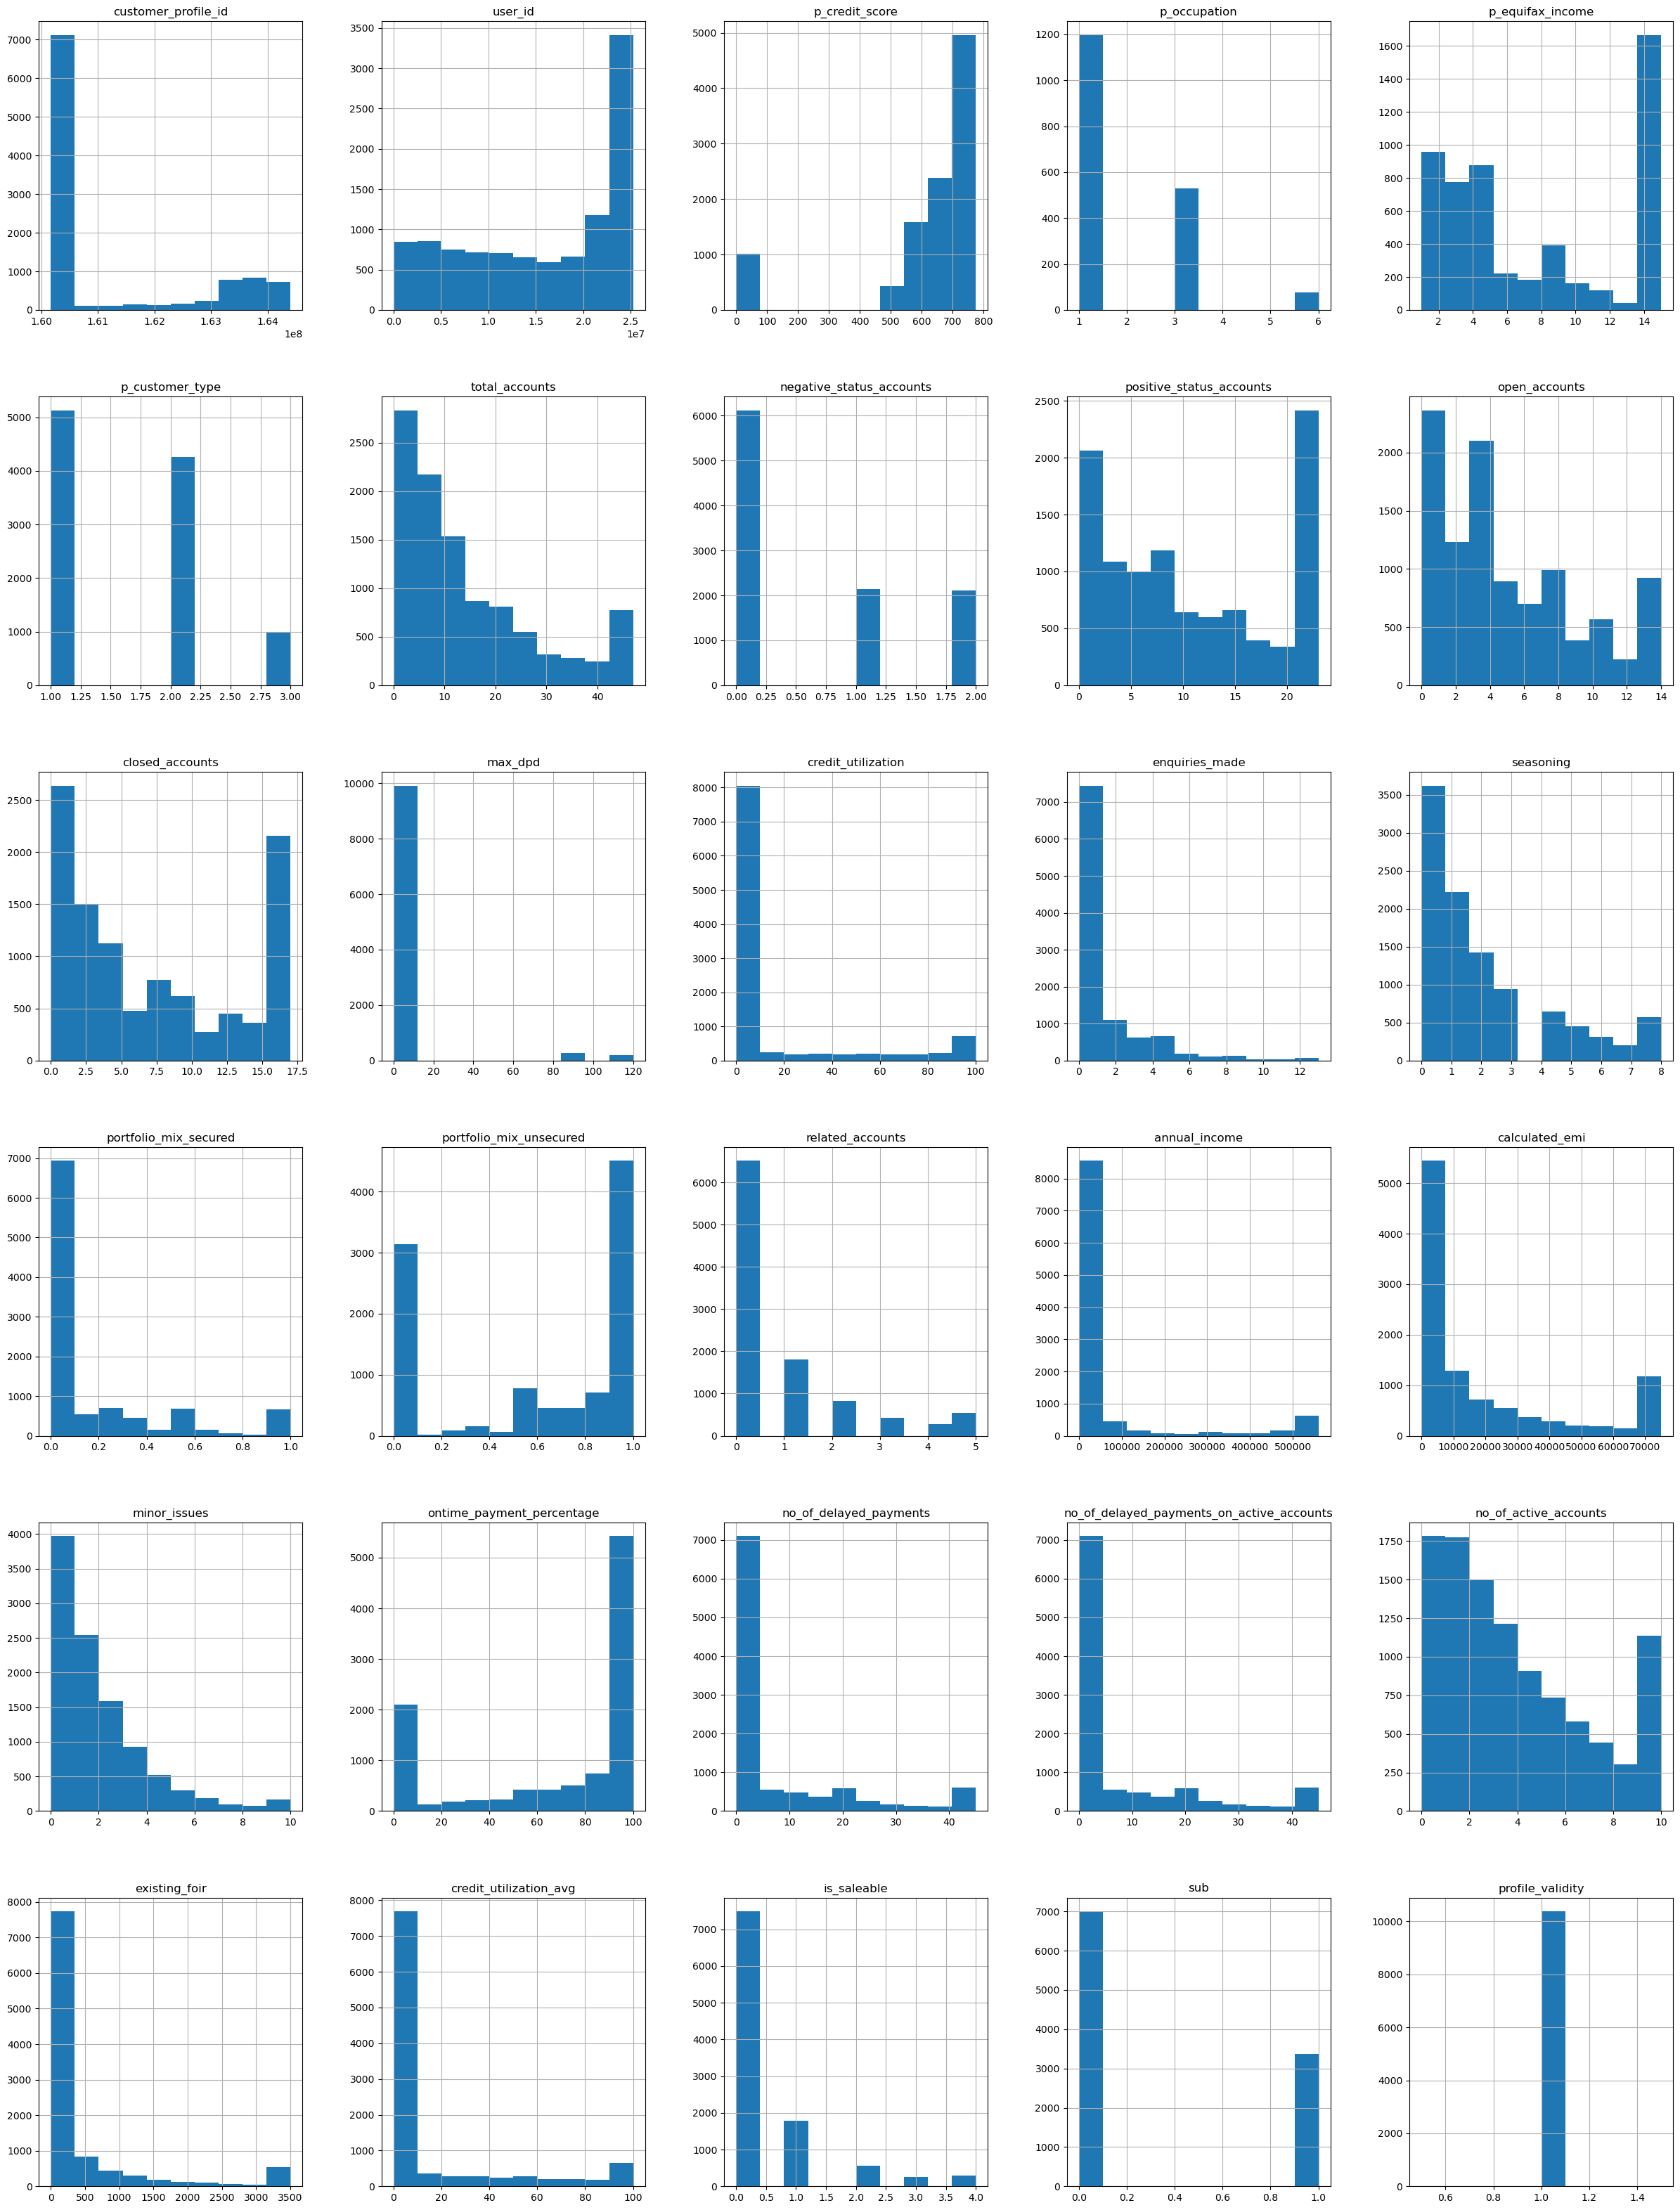

In [10]:
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
ch_data.hist(ax = ax)
pyplot.show()

In [11]:
ch_data.isnull().sum()

customer_profile_id                             0
user_id                                         0
p_credit_score                                  0
p_occupation                                 8574
p_equifax_income                             4984
p_customer_type                                 0
total_accounts                                  0
negative_status_accounts                        0
positive_status_accounts                        0
open_accounts                                   0
closed_accounts                                 0
max_dpd                                         0
credit_utilization                              0
enquiries_made                                  0
seasoning                                       0
portfolio_mix_secured                           0
portfolio_mix_unsecured                         0
related_accounts                                0
annual_income                                   0
calculated_emi                                  0


In [12]:
''' get_occupation '''
def get_occupation(occupation):
    try:
        if occupation == 9:
            return 'Student'
        elif occupation in [1,2]:
            return 'Salaried'
        elif occupation in [3,4,5,6,7,8]:
            return 'SelfEmployed'
        elif occupation in [10,11]:
            return 'Other'
        else:
            return 'Other'
    except:
        return 'Other'
ch_data['p_occupation'] = ch_data['p_occupation'].apply(lambda x: get_occupation(x))
ch_data['p_occupation'].value_counts()

Other           8574
Salaried        1197
SelfEmployed     605
Name: p_occupation, dtype: int64

In [13]:
''' get_salary '''
def get_salary(salary):
    try:
        if salary == 1:
            return '<10k'
        elif salary == 2:
            return '10-15k'
        elif salary == 3:
            return '15-20k'
        elif salary == 4:
            return '20-25k'
        elif salary == 5:
            return '25-30k'
        elif salary == 6:
            return '30-35k'
        elif salary == 7:
            return '35-40k'
        elif salary == 8:
            return '40-45k'
        elif salary == 9:
            return '40-45k'
        elif salary == 10:
            return '40-45k'
        elif salary == 11:
            return '40-45k'
        elif salary == 12:
            return '40-45k'
        elif salary == 13:
            return '40-45k'
        elif salary ==14:
            return '40-45k'
        elif salary == 15:
            return '40-45k'
        else:
            return 'Other'
    except:
        return 'Other'
ch_data['p_equifax_income'] = ch_data['p_equifax_income'].apply(lambda x: get_salary(x))
ch_data['p_equifax_income'].value_counts()

Other     4984
40-45k    2380
15-20k     773
10-15k     632
20-25k     523
25-30k     355
<10k       326
30-35k     220
35-40k     183
Name: p_equifax_income, dtype: int64

In [14]:
''' get_p_customer_type '''
def get_p_customer_type(type):
    try:
        if type == 1:
            return 'Green'
        elif type == 2:
            return 'Red'
        else:
            return 'Amber'
    except:
        return 'Amber'
ch_data['p_customer_type'] = ch_data['p_customer_type'].apply(lambda x: get_p_customer_type(x))
ch_data['p_customer_type'].value_counts()

Green    5131
Red      4258
Amber     987
Name: p_customer_type, dtype: int64

In [15]:
joblib.dump(ch_data, 'ch_clean_data_hl.pkl')

['ch_clean_data_hl.pkl']

In [16]:
ch_data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,customer_profile_id,user_id,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable,sub,profile_validity
customer_profile_id,1.0,-0.35,0.16,0.26,0.11,0.3,0.27,0.27,-0.0056,0.22,0.065,0.23,0.13,0.15,0.28,0.24,0.39,0.0037,0.24,0.068,0.068,0.34,0.2,0.17,0.16,0.92,nan
user_id,-0.35,1.0,-0.21,-0.4,-0.24,-0.44,-0.38,-0.42,-0.044,-0.27,-0.064,-0.18,-0.089,-0.17,-0.28,-0.23,-0.35,-0.23,-0.2,-0.2,-0.2,-0.37,-0.21,-0.26,-0.24,-0.34,nan
p_credit_score,0.16,-0.21,1.0,0.24,0.021,0.34,0.29,0.27,-0.017,0.12,0.14,0.26,0.15,0.36,0.12,0.11,0.19,0.16,0.48,-0.0066,-0.0066,0.28,0.11,0.12,0.01,0.18,nan
total_accounts,0.26,-0.4,0.24,1.0,0.29,0.92,0.78,0.91,0.071,0.33,0.33,0.56,0.087,0.31,0.43,0.19,0.49,0.59,0.32,0.29,0.29,0.7,0.42,0.31,0.25,0.26,nan
negative_status_accounts,0.11,-0.24,0.021,0.29,1.0,0.21,0.26,0.29,0.28,0.086,0.041,-0.084,0.1,-0.057,0.22,0.061,0.16,0.26,-0.16,0.68,0.68,0.2,0.14,0.12,0.71,0.079,nan
positive_status_accounts,0.3,-0.44,0.34,0.92,0.21,1.0,0.78,0.94,0.039,0.34,0.32,0.58,0.11,0.38,0.42,0.23,0.51,0.53,0.42,0.22,0.22,0.72,0.41,0.32,0.17,0.3,nan
open_accounts,0.27,-0.38,0.29,0.78,0.26,0.78,1.0,0.62,0.081,0.44,0.36,0.74,0.077,0.43,0.43,0.28,0.61,0.68,0.44,0.3,0.3,0.92,0.44,0.41,0.24,0.27,nan
closed_accounts,0.27,-0.42,0.27,0.91,0.29,0.94,0.62,1.0,0.059,0.27,0.26,0.42,0.11,0.25,0.4,0.17,0.42,0.46,0.28,0.26,0.26,0.56,0.37,0.25,0.24,0.27,nan
max_dpd,-0.0056,-0.044,-0.017,0.071,0.28,0.039,0.081,0.059,1.0,-0.0033,0.033,-0.029,0.025,-0.043,0.083,0.0012,0.04,0.11,-0.077,0.23,0.23,0.051,0.044,0.0094,0.19,-0.0095,nan
credit_utilization,0.22,-0.27,0.12,0.33,0.086,0.34,0.44,0.27,-0.0033,1.0,0.15,0.34,-0.022,0.26,0.17,0.24,0.34,0.19,0.23,0.14,0.14,0.47,0.21,0.82,0.12,0.23,nan


In [17]:
exclude=['profile_validity']

In [18]:
numerical_columns=list(ch_data.select_dtypes(include='number').columns)
for feature in numerical_columns:
    if feature in exclude:
        pass
    else:
        numerical_columns.remove(feature)
print(numerical_columns)

['user_id', 'total_accounts', 'positive_status_accounts', 'closed_accounts', 'credit_utilization', 'seasoning', 'portfolio_mix_unsecured', 'annual_income', 'minor_issues', 'no_of_delayed_payments', 'no_of_active_accounts', 'credit_utilization_avg', 'sub', 'profile_validity']


In [19]:
skewed=[]
def find_skew(data,numerical_columns):
    skew_list={}
    for feature in numerical_columns:
        try:
            try:
                skew_value=(3*(data[feature].mean()-data[feature].median()))/data[feature].std()
                if ((round(skew_value,2)<-3) or (round(skew_value,2)>3)):
                    skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                    skewed.append(feature)
                else:
                    skew_list[feature]=round(skew_value,2)
            except ZeroDivisionError:
                skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                skewed.append(feature)
        except:
            pass
    return skew_list
skew_list=find_skew(ch_data,numerical_columns)
skew_list

{'user_id': -0.88,
 'total_accounts': 0.96,
 'positive_status_accounts': 0.69,
 'closed_accounts': 1.05,
 'credit_utilization': 1.44,
 'seasoning': 1.28,
 'portfolio_mix_unsecured': -1.39,
 'annual_income': 1.09,
 'minor_issues': 0.84,
 'no_of_delayed_payments': 1.74,
 'no_of_active_accounts': 0.44,
 'credit_utilization_avg': 1.54,
 'sub': 2.08,
 'profile_validity': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'}

In [20]:
for i in numerical_columns:
    if i in exclude:
        pass
    else:
        try:
            ch_data[i] =stats.boxcox(array)
        except:
            pass
find_skew(ch_data,numerical_columns)

{'user_id': -0.88,
 'total_accounts': 0.96,
 'positive_status_accounts': 0.69,
 'closed_accounts': 1.05,
 'credit_utilization': 1.44,
 'seasoning': 1.28,
 'portfolio_mix_unsecured': -1.39,
 'annual_income': 1.09,
 'minor_issues': 0.84,
 'no_of_delayed_payments': 1.74,
 'no_of_active_accounts': 0.44,
 'credit_utilization_avg': 1.54,
 'sub': 2.08,
 'profile_validity': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'}

In [21]:
joblib.dump(ch_data, 'ch_transformed_data_hl.pkl')

['ch_transformed_data_hl.pkl']

In [22]:
user_ids=pd.concat([ch_data['user_id'].reset_index(drop = True)], axis = 1)
ch_data.drop(['user_id'],axis=1,inplace=True)

In [23]:
customer_profile_id=pd.concat([ch_data['customer_profile_id'].reset_index(drop = True)], axis = 1)
ch_data.drop(['customer_profile_id'],axis=1,inplace=True)

In [24]:
categorical_features=list(ch_data.select_dtypes(exclude='number').columns)
categorical_features

['p_occupation', 'p_equifax_income', 'p_customer_type']

In [25]:
exemption_features=['sub']

In [26]:
numeric_features=list(ch_data.select_dtypes(include='number').columns)
numeric_features
flag_features=[]
for feature in exemption_features:
    numeric_features.remove(feature)
for feature in exclude:
    if feature in numeric_features:
        flag_features.append(feature)
        numeric_features.remove(feature)

In [27]:
id_columns=['user_id','customer_profile_id']
exemption_features=['sub']

In [28]:
dummies = pd.get_dummies(data = ch_data[categorical_features], drop_first=False)
dummies.columns

Index(['p_occupation_Other', 'p_occupation_Salaried',
       'p_occupation_SelfEmployed', 'p_equifax_income_10-15k',
       'p_equifax_income_15-20k', 'p_equifax_income_20-25k',
       'p_equifax_income_25-30k', 'p_equifax_income_30-35k',
       'p_equifax_income_35-40k', 'p_equifax_income_40-45k',
       'p_equifax_income_<10k', 'p_equifax_income_Other',
       'p_customer_type_Amber', 'p_customer_type_Green',
       'p_customer_type_Red'],
      dtype='object')

In [29]:
'''Scaling numeric features'''
standard_scalar = StandardScaler(with_mean=True,with_std=True)
standard_scalar.fit(ch_data[numeric_features])
numeric_data_scaled = standard_scalar.transform(ch_data[numeric_features])
numeric_data_scaled = pd.DataFrame(numeric_data_scaled,columns=numeric_features)
numeric_data_scaled.head()

,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable
0,0.65,-0.02,-0.76,0.38,-0.24,0.45,-0.21,-0.48,-0.59,0.01,1.20,-0.23,-0.59,-0.44,-0.59,0.23,0.79,-0.58,-0.58,-0.47,-0.18,-0.51,-0.51
1,0.53,-0.32,0.48,-0.23,-0.24,-0.19,-0.21,-0.48,-0.59,-0.43,-0.56,0.93,-0.59,-0.36,-0.65,0.23,0.79,-0.58,-0.58,-0.47,-0.48,-0.51,-0.51
2,0.77,-0.92,-0.76,-1.08,-0.97,-0.98,-0.21,-0.48,-0.59,-0.43,-0.56,0.93,-0.59,-0.36,-0.73,-0.79,0.79,-0.58,-0.58,-0.80,-0.48,-0.51,-0.51
3,0.77,0.87,0.48,1.47,0.25,1.56,-0.21,-0.48,-0.59,-0.86,2.96,-1.39,-0.59,-0.41,-0.27,1.76,0.67,-0.50,-0.50,-0.80,0.24,-0.51,-0.51
4,0.53,0.87,-0.76,1.47,1.94,0.92,-0.21,1.69,0.81,1.75,-0.56,0.93,-0.59,-0.25,0.15,2.27,0.76,-0.50,-0.50,1.15,0.17,1.38,-0.51


In [30]:
'''Concatenating all features'''
processed_dataset = pd.concat([user_ids['user_id'].reset_index(drop = True), 
                               customer_profile_id['customer_profile_id'].reset_index(drop = True), 
                               numeric_data_scaled.reset_index(drop = True),
                               ch_data[flag_features].reset_index(drop = True),
                               dummies.reset_index(drop = True),
                              ch_data[exemption_features].reset_index(drop = True)
                              ], axis=1)
processed_dataset.shape

(10376, 42)

In [31]:
joblib.dump(processed_dataset, 'ch_processed_data_hl.pkl')

['ch_processed_data_hl.pkl']

In [32]:
processed_dataset.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,user_id,customer_profile_id,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable,profile_validity,p_occupation_Other,p_occupation_Salaried,p_occupation_SelfEmployed,p_equifax_income_10-15k,p_equifax_income_15-20k,p_equifax_income_20-25k,p_equifax_income_25-30k,p_equifax_income_30-35k,p_equifax_income_35-40k,p_equifax_income_40-45k,p_equifax_income_<10k,p_equifax_income_Other,p_customer_type_Amber,p_customer_type_Green,p_customer_type_Red,sub
user_id,1.0,-0.35,-0.21,-0.4,-0.24,-0.44,-0.38,-0.42,-0.044,-0.27,-0.064,-0.18,-0.089,-0.17,-0.28,-0.23,-0.35,-0.23,-0.2,-0.2,-0.2,-0.37,-0.21,-0.26,-0.24,nan,0.12,-0.1,-0.045,0.032,0.025,-0.021,-0.048,-0.031,-0.051,-0.29,-0.063,0.28,0.27,0.072,-0.23,-0.34
customer_profile_id,-0.35,1.0,0.16,0.26,0.11,0.3,0.27,0.27,-0.0056,0.22,0.065,0.23,0.13,0.15,0.28,0.24,0.39,0.0037,0.24,0.068,0.068,0.34,0.2,0.17,0.16,nan,-0.11,0.1,0.032,-0.046,-0.056,-0.02,0.011,0.021,0.026,0.27,0.054,-0.21,-0.18,-0.035,0.14,0.92
p_credit_score,-0.21,0.16,1.0,0.24,0.021,0.34,0.29,0.27,-0.017,0.12,0.14,0.26,0.15,0.36,0.12,0.11,0.19,0.16,0.48,-0.0066,-0.0066,0.28,0.11,0.12,0.01,nan,-0.12,0.11,0.041,0.067,0.08,0.052,0.04,0.034,0.031,0.14,0.048,-0.26,-0.93,0.5,0.047,0.18
total_accounts,-0.4,0.26,0.24,1.0,0.29,0.92,0.78,0.91,0.071,0.33,0.33,0.56,0.087,0.31,0.43,0.19,0.49,0.59,0.32,0.29,0.29,0.7,0.42,0.31,0.25,nan,-0.079,0.046,0.065,0.057,0.086,0.093,0.095,0.095,0.08,0.3,0.06,-0.47,-0.33,-0.049,0.25,0.26
negative_status_accounts,-0.24,0.11,0.021,0.29,1.0,0.21,0.26,0.29,0.28,0.086,0.041,-0.084,0.1,-0.057,0.22,0.061,0.16,0.26,-0.16,0.68,0.68,0.2,0.14,0.12,0.71,nan,-0.053,0.03,0.044,0.047,0.039,0.061,0.054,0.042,0.033,0.13,0.043,-0.24,-0.25,-0.76,0.92,0.079
positive_status_accounts,-0.44,0.3,0.34,0.92,0.21,1.0,0.78,0.94,0.039,0.34,0.32,0.58,0.11,0.38,0.42,0.23,0.51,0.53,0.42,0.22,0.22,0.72,0.41,0.32,0.17,nan,-0.092,0.06,0.066,0.062,0.086,0.098,0.1,0.09,0.08,0.34,0.071,-0.51,-0.4,0.048,0.19,0.3
open_accounts,-0.38,0.27,0.29,0.78,0.26,0.78,1.0,0.62,0.081,0.44,0.36,0.74,0.077,0.43,0.43,0.28,0.61,0.68,0.44,0.3,0.3,0.92,0.44,0.41,0.24,nan,-0.088,0.066,0.052,0.024,0.036,0.051,0.083,0.076,0.054,0.35,0.06,-0.44,-0.35,-0.0055,0.22,0.27
closed_accounts,-0.42,0.27,0.27,0.91,0.29,0.94,0.62,1.0,0.059,0.27,0.26,0.42,0.11,0.25,0.4,0.17,0.42,0.46,0.28,0.26,0.26,0.56,0.37,0.25,0.24,nan,-0.074,0.043,0.062,0.076,0.1,0.11,0.1,0.091,0.081,0.29,0.066,-0.49,-0.36,-0.041,0.26,0.27
max_dpd,-0.044,-0.0056,-0.017,0.071,0.28,0.039,0.081,0.059,1.0,-0.0033,0.033,-0.029,0.025,-0.043,0.083,0.0012,0.04,0.11,-0.077,0.23,0.23,0.051,0.044,0.0094,0.19,nan,-0.0015,-0.02,0.029,0.023,-0.0087,0.017,0.018,0.0023,8.3e-05,0.038,0.0056,-0.055,-0.069,-0.21,0.26,-0.0095
credit_utilization,-0.27,0.22,0.12,0.33,0.086,0.34,0.44,0.27,-0.0033,1.0,0.15,0.34,-0.022,0.26,0.17,0.24,0.34,0.19,0.23,0.14,0.14,0.47,0.21,0.82,0.12,nan,-0.088,0.081,0.032,-0.02,-0.015,-0.028,0.017,0.037,0.022,0.25,0.043,-0.22,-0.15,0.015,0.073,0.23


In [33]:
ch_data.describe(percentiles=[0.01,0.05,0.10,0.25,0.5,0.75,0.9,0.95,0.99],datetime_is_numeric=True).transpose()

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
p_credit_score,10376.00,611.78,213.26,0.00,0.00,0.00,500.00,575.00,675.00,725.00,775.00,775.00,775.00,775.00
total_accounts,10376.00,14.30,13.39,0.00,0.00,0.00,1.00,4.00,10.00,21.00,37.00,47.00,47.00,47.00
negative_status_accounts,10376.00,0.61,0.80,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,2.00,2.00
positive_status_accounts,10376.00,10.90,8.26,0.00,0.00,0.00,1.00,3.75,9.00,19.00,23.00,23.00,23.00,23.00
open_accounts,10376.00,4.99,4.13,0.00,0.00,0.00,0.00,2.00,4.00,7.00,12.00,14.00,14.00,14.00
closed_accounts,10376.00,7.19,6.29,0.00,0.00,0.00,0.00,1.00,5.00,13.00,17.00,17.00,17.00,17.00
max_dpd,10376.00,4.58,21.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,120.00
credit_utilization,10376.00,14.54,30.32,0.00,0.00,0.00,0.00,0.00,0.00,0.88,74.26,97.20,100.00,100.00
enquiries_made,10376.00,1.26,2.13,0.00,0.00,0.00,0.00,0.00,0.00,2.00,4.00,6.00,10.00,13.00
seasoning,10376.00,1.98,2.30,0.00,0.00,0.00,0.00,0.00,1.00,3.00,6.00,8.00,8.00,8.00


In [34]:
'''Replace Infinite'''
processed_dataset = processed_dataset.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
processed_dataset.shape

(10376, 42)

In [111]:
data=processed_dataset[[
'p_customer_type_Red',
'p_customer_type_Green',
'p_occupation_Salaried',
'p_equifax_income_Other',
'p_occupation_SelfEmployed',
'p_occupation_Other',
'p_equifax_income_40-45k',
'negative_status_accounts',
'is_saleable',
'credit_utilization',
'credit_utilization_avg',
'portfolio_mix_secured',
'no_of_delayed_payments_on_active_accounts',
'no_of_delayed_payments',
'related_accounts',
'portfolio_mix_unsecured',
'open_accounts',
'enquiries_made',
'no_of_active_accounts',
'minor_issues',
'closed_accounts',
'annual_income',
'existing_foir',
'seasoning',
'ontime_payment_percentage',
'p_credit_score',
'positive_status_accounts',
'total_accounts',
'calculated_emi',
]]

In [112]:
'''  Splitting test and train data '''
data=processed_dataset.drop(['customer_profile_id','profile_validity'],axis=1)

X = data.loc[:,data.columns != 'sub']
y = data['sub']
train_X_u,test_X_u,train_y,test_y = train_test_split(X,y,random_state=13,test_size=0.1)
train_X = train_X_u.loc[:,train_X_u.columns != 'user_id']
test_X = test_X_u.loc[:,test_X_u.columns != 'user_id']

In [113]:
train_X.head()

,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable,p_occupation_Other,p_occupation_Salaried,p_occupation_SelfEmployed,p_equifax_income_10-15k,p_equifax_income_15-20k,p_equifax_income_20-25k,p_equifax_income_25-30k,p_equifax_income_30-35k,p_equifax_income_35-40k,p_equifax_income_40-45k,p_equifax_income_<10k,p_equifax_income_Other,p_customer_type_Amber,p_customer_type_Green,p_customer_type_Red
6602,0.18,-0.69,0.48,-0.84,-0.48,-0.83,-0.21,-0.48,-0.59,0.01,2.96,-1.39,-0.59,-0.36,-0.65,-0.79,-0.22,1.23,1.23,-0.15,-0.48,-0.51,0.59,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
9277,0.06,-0.92,1.73,-1.32,-0.72,-1.14,3.98,-0.48,-0.12,-0.86,-0.56,-1.39,-0.59,-0.36,-0.63,-0.28,-0.81,0.52,0.52,-0.80,-0.48,-0.51,-0.51,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
8898,0.06,-0.17,0.48,0.01,-0.48,0.29,3.98,-0.48,-0.59,-0.43,2.96,-1.39,-0.59,0.46,-0.52,-0.28,0.19,0.20,0.20,-0.47,-0.43,-0.51,-0.51,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
7170,0.65,-0.47,-0.76,-0.35,-0.24,-0.51,-0.21,-0.48,0.35,0.01,-0.56,0.93,-0.59,-0.42,-0.64,0.23,0.79,-0.58,-0.58,-0.47,-0.31,-0.51,-0.51,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4743,0.65,-0.69,-0.76,-0.71,-0.24,-0.98,-0.21,-0.03,0.35,0.45,-0.56,0.93,-0.59,-0.36,-0.67,-0.79,0.79,-0.58,-0.58,0.18,-0.48,-0.04,-0.51,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [114]:
#RandomForest
''' Tuning Grid '''
gridParams = {
#                 'n_estimators': [100],
#                 'max_features':['sqrt'],
#                 'bootstrap': [True],
                'random_state' : [12],
#                 'warm_start':[False],
                'criterion':['gini', 'entropy'],
#                 'max_depth':[47],
                'min_samples_split':[0.00000002,0.00000003,0.00000004,0.00000005],
                'min_samples_leaf':[0.0000002,0.0000003,0.0000004,0.0000005]
             }

'''Model Object'''
model2 = RandomForestClassifier()

''' Grid Formation '''
grid = RandomizedSearchCV(estimator = model2 , param_distributions= gridParams, verbose = 2, cv = 3, n_iter=1000)
grid.fit(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 32 is smaller than n_iter=1000. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=2e-08, random_state=12; total time=   0.6s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=2e-08, random_state=12; total time=   0.7s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=2e-08, random_state=12; total time=   0.6s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=3e-08, random_state=12; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=3e-08, random_state=12; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=3e-08, random_state=12; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=4e-08, random_state=12; total time=   0.5s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_samples_split=4e-08, random_state=12; total time=   0.6s
[CV] END criterion=gini, min_samples_leaf=2e-07, min_sample

[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=2e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=3e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=3e-08, random_state=12; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=3e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=4e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=4e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=4e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=5e-08, random_state=12; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=4e-07, min_samples_split=5e-08, random_state=12; to

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=1000,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [2e-07, 3e-07,
                                                             4e-07, 5e-07],
                                        'min_samples_split': [2e-08, 3e-08,
                                                              4e-08, 5e-08],
                                        'random_state': [12]},
                   verbose=2)

In [282]:
#RandomForest

'''Model Object'''
model = RandomForestClassifier(criterion='entropy', min_samples_split=0.007, min_samples_leaf=0.0001,  random_state=15)
model.fit(train_X, train_y)

RandomForestClassifier(criterion='entropy', min_samples_leaf=0.0001,
                       min_samples_split=0.007, random_state=15)

In [283]:
dict(sorted(dict(zip(grid.feature_names_in_, model.feature_importances_)).items(), key=lambda item: item[1]))

{'p_equifax_income_30-35k': 0.0019192365552807692,
 'p_equifax_income_<10k': 0.0019932119776666143,
 'p_equifax_income_35-40k': 0.002026122166668558,
 'max_dpd': 0.002181679030596028,
 'p_equifax_income_25-30k': 0.0022454965289331135,
 'p_equifax_income_20-25k': 0.0023900767220549814,
 'p_equifax_income_10-15k': 0.002453223371443152,
 'p_occupation_SelfEmployed': 0.002681857976317173,
 'p_equifax_income_15-20k': 0.0030434498881263474,
 'p_occupation_Other': 0.0035337264511986276,
 'p_occupation_Salaried': 0.003744304136671262,
 'p_customer_type_Green': 0.00409963896785477,
 'p_customer_type_Red': 0.004359851898946995,
 'p_equifax_income_Other': 0.004986128082821548,
 'negative_status_accounts': 0.0064338875469450284,
 'p_customer_type_Amber': 0.006884256296679416,
 'p_equifax_income_40-45k': 0.011979670241151591,
 'enquiries_made': 0.014048994868019528,
 'seasoning': 0.015552246445817753,
 'no_of_delayed_payments': 0.016587350962325654,
 'no_of_delayed_payments_on_active_accounts': 0.0

In [284]:
dict(sorted(dict(zip(model.feature_names_in_, model.feature_importances_)).items(), key=lambda item: item[1]))

{'p_equifax_income_30-35k': 0.0019192365552807692,
 'p_equifax_income_<10k': 0.0019932119776666143,
 'p_equifax_income_35-40k': 0.002026122166668558,
 'max_dpd': 0.002181679030596028,
 'p_equifax_income_25-30k': 0.0022454965289331135,
 'p_equifax_income_20-25k': 0.0023900767220549814,
 'p_equifax_income_10-15k': 0.002453223371443152,
 'p_occupation_SelfEmployed': 0.002681857976317173,
 'p_equifax_income_15-20k': 0.0030434498881263474,
 'p_occupation_Other': 0.0035337264511986276,
 'p_occupation_Salaried': 0.003744304136671262,
 'p_customer_type_Green': 0.00409963896785477,
 'p_customer_type_Red': 0.004359851898946995,
 'p_equifax_income_Other': 0.004986128082821548,
 'negative_status_accounts': 0.0064338875469450284,
 'p_customer_type_Amber': 0.006884256296679416,
 'p_equifax_income_40-45k': 0.011979670241151591,
 'enquiries_made': 0.014048994868019528,
 'seasoning': 0.015552246445817753,
 'no_of_delayed_payments': 0.016587350962325654,
 'no_of_delayed_payments_on_active_accounts': 0.0

In [285]:
joblib.dump(grid,"CH_HL_RF_v1.pkl")

['CH_HL_RF_v1.pkl']

In [286]:
joblib.dump(model,"CH_HL_RF_v1.1.pkl")

['CH_HL_RF_v1.1.pkl']

In [287]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_leaf=2e-07,
                       min_samples_split=2e-08, random_state=12)

In [288]:
test_fit2 = grid.predict(test_X)
y_pred=pd.DataFrame(test_fit2)

In [289]:
test_fit1 = model.predict(test_X)
y_pred1=pd.DataFrame(test_fit1)

In [290]:
test_fit3 = model.predict(train_X)
y_pred3=pd.DataFrame(test_fit3)

In [291]:
accuracy_score(test_y, y_pred)

0.7581888246628131

In [292]:
accuracy_score(test_y, y_pred1)

0.7687861271676301

In [293]:
accuracy_score(train_y, y_pred3)

0.8205183122724352

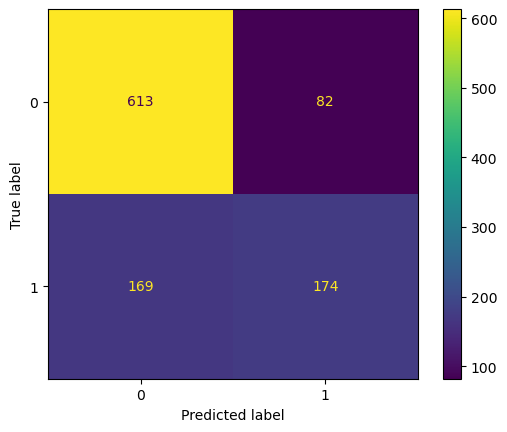

In [294]:
cm=ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
cm.plot()
plt.show()

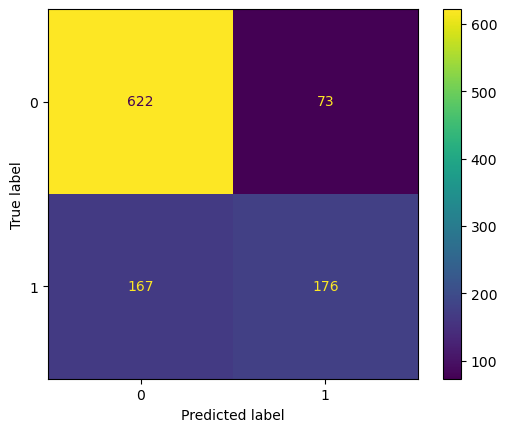

In [295]:
cm=ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred1))
cm.plot()
plt.show()

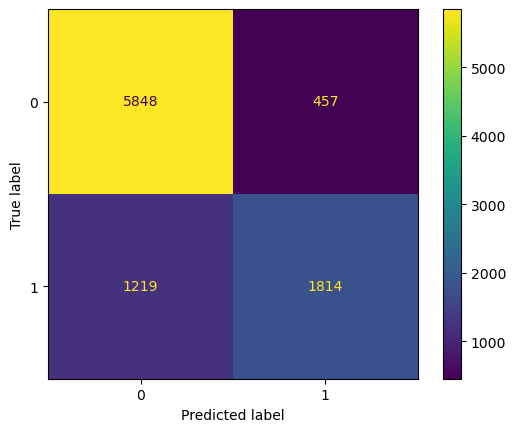

In [296]:
cm=ConfusionMatrixDisplay(confusion_matrix(train_y, y_pred3))
cm.plot()
plt.show()

In [297]:
false_positive_rate, true_positive_rate, threshold1 = roc_curve(test_y, y_pred)
'roc='+str(roc_auc_score(test_y, y_pred))

'roc=0.694651509113409'

In [298]:
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(test_y, y_pred1)
'roc='+str(roc_auc_score(test_y, y_pred1))

'roc=0.7040417811523376'

In [299]:
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(train_y, y_pred3)
'roc='+str(roc_auc_score(train_y, y_pred3))

'roc=0.7628027724635147'

In [300]:
mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(test_y, y_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.2418111753371869
MSE: 0.2418111753371869
RMSE: 0.4917429972426521
R-Squared: -0.09292950479266748


In [301]:
mae = mean_absolute_error(test_y, y_pred1)
mse = mean_squared_error(test_y, y_pred1)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(test_y, y_pred1)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.23121387283236994
MSE: 0.23121387283236994
RMSE: 0.480847036834345
R-Squared: -0.045032195817690024


In [302]:
mae = mean_absolute_error(train_y, y_pred3)
mse = mean_squared_error(train_y, y_pred3)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(train_y, y_pred3)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.1794816877275648
MSE: 0.1794816877275648
RMSE: 0.4236527914785465
R-Squared: 0.18159102633390622


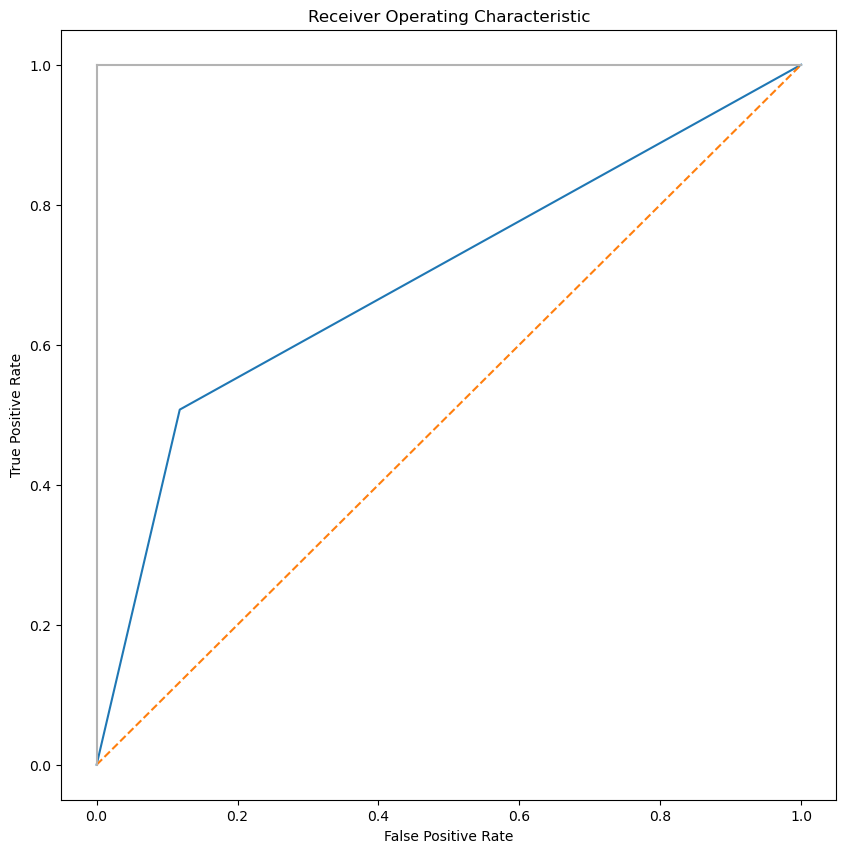

In [303]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

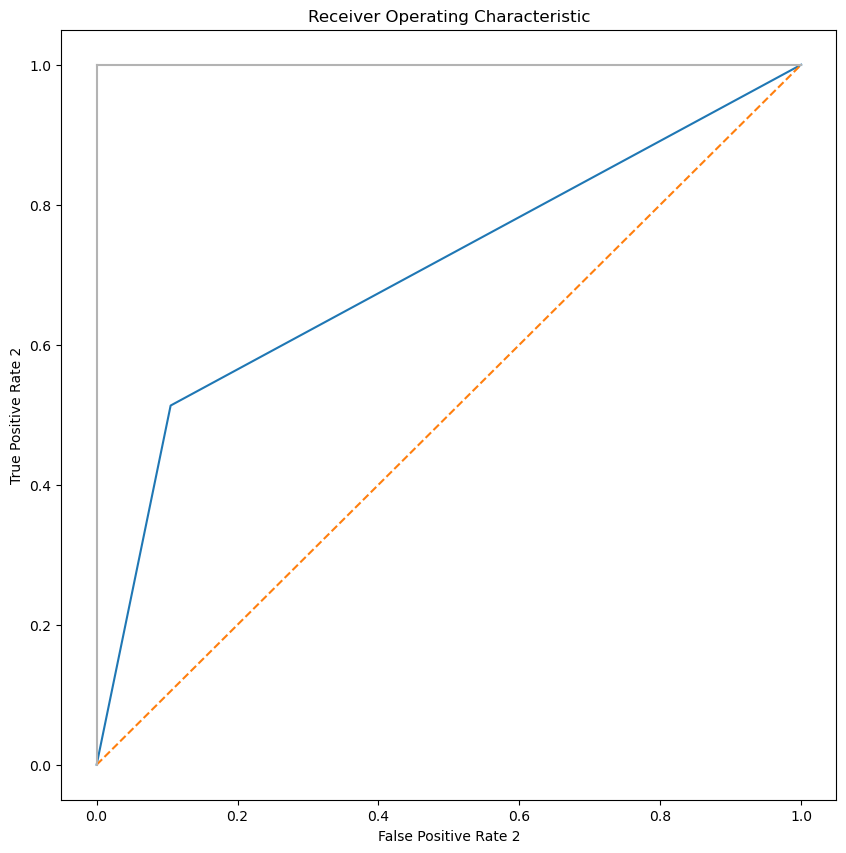

In [304]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate 2')
plt.xlabel('False Positive Rate 2')
plt.show()

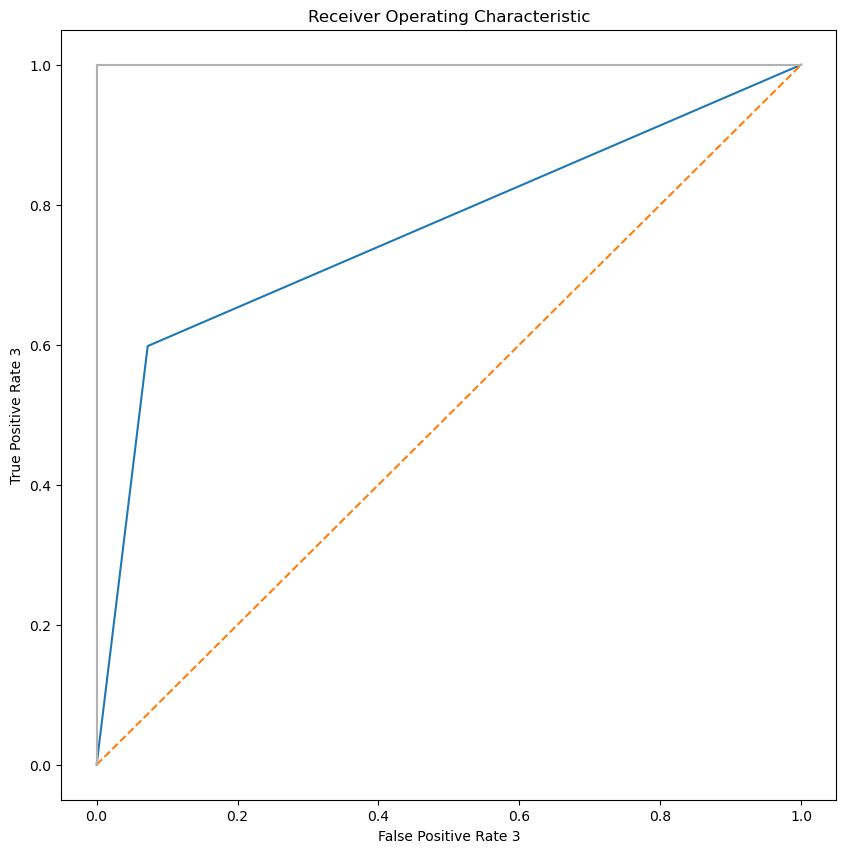

In [305]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate 3')
plt.xlabel('False Positive Rate 3')
plt.show()